## Software Requirements

In [ ]:
!conda env create -f environment.yml

In [ ]:
!conda activate thesis

In [1]:
# Data visualization
import matplotlib.pyplot as plt 

# Data manipulation
import pandas as pd
import numpy as np
import csv
from zipfile import ZipFile

In [2]:
# Webscraping
import glob
import requests
from bs4 import BeautifulSoup
import time
import datetime
from pandas.core.common import flatten
import os
from itertools import chain
from tqdm import tqdm
import json
import urllib.request

In [3]:
# Parsing and pre-processing
from glob import glob
import os 
import re

from pdfminer.high_level import extract_text
import pdfplumber
from langdetect import detect, DetectorFactory

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from string import punctuation
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [4]:
# Vector representations and embeddings
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim

In [5]:
# Logistic and XGboost
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_score, recall_score
from xgboost import XGBClassifier
import pickle

In [6]:
# LSTM 
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import gc

c:\Users\admin\anaconda3\envs\thesis\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# BERT models
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler
import transformers
from transformers import AutoModel, BertTokenizerFast

In [8]:
# specify GPU
device = "cuda" if torch.cuda.is_available() else "cpu"

## Data Pre-processing

In [33]:
df = pd.read_json(r"../../../data/processed/data_merged_2023_02_28.json")

### Add length of sec_text

In [34]:
df['count'] = df['sec_text'].str.split().apply(len)

<AxesSubplot: >

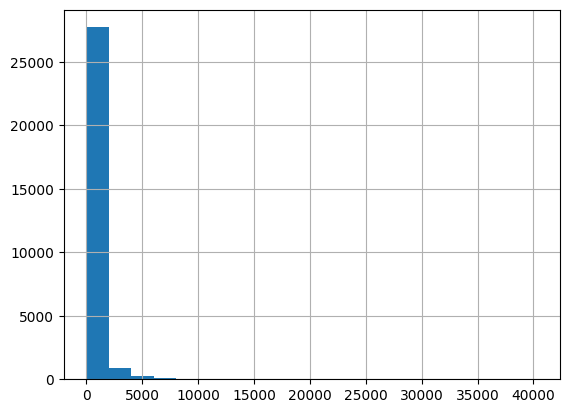

In [35]:
pd.Series(df['count']).hist(bins = 20)

In [36]:
len(df[df['count']<=2500])

28051

In [37]:
df[df['count']<50]['sec_text']

0        EUROPEAN COMMISSION\nBrussels, 05.03.2021\nC(2...
9        EUROPEAN COMMISSION\nBrussels, 19.1.2021\nC(20...
21       INTERNATIONAL\nOnly the English  text is avail...
22       EUROPEAN COMMISSION\nBrussels,  29.3.2022\nC(2...
35       East  Coast  South  America-Mediterranean  ([4...
                               ...                        
28913    Ref.:   Letter of the Bundeskartellamt of 7 Fe...
28921    (10)  On 25 October 2019, Discovery and Polsat...
28943    […]\nSource: Form CO, Annex 22A – Triton 5.4 D...
28967    (9)  Both Parties will contribute all of their...
28977    (16)  The UOKiK made a request under Article 9...
Name: sec_text, Length: 4433, dtype: object

### Drop count with sec_text <=20

In [38]:
df = df[df['count']>20].reset_index(drop=True)

#### Drop based on 'section'/subheading

In [39]:
headings = df['section'].value_counts()

In [54]:
# remove based on subheading/section
section_list = ['en', 'merger procedure', 'commission decision', 'No 139/20041',
                                             'PUBLIC VERSION', 'Area2', 'N', 'REGULATION (EC) No 139/2004',
                                             'Regulation No 139/20041',
                                             'REGULATION (EC) 139/2004', 'Economic Area3']
                                            #  'Commission europØenne, B-1049 Bruxelles / Europese Commissie, B-1049 Brussel - Belgium. Telephone: (32-2) 299 11 11. II. THE OPERATION',
                                            #  'Commission européenne, B-1049 Bruxelles / Europese Commissie, B-1049 Brussel - Belgium. Telephone: (32-2) 299 11 11.  I.  THE PARTIES',
                                            #  'Commission européenne, B-1049 Bruxelles / Europese Commissie, B-1049 Brussel - Belgium. Telephone: (32-2) 299 11 11.  II.  THE OPERATION',
                                            #  'Tel: +32 229-91111. Fax: +32 229-64301. E-mail: COMP-MERGER-REGISTRY@ec.europa.eu.  I.  THE PARTIES',
                                            #  'Commission européenne, 1049 Bruxelles, BELGIQUE / Europese Commissie, 1049 Brussel, BELGIË. Tel.: +32 229-91111.  1.  THE PARTIES'

lowercase_list = [text.lower() for text in section_list]


keep_mask = ~df['section'].str.lower().isin(lowercase_list)
df = df[keep_mask].reset_index(drop=True)

In [55]:
# no of cases by article
df.groupby('article')['case_num'].nunique()

article
art6.0    4684
art6.1     219
art8.1      32
art8.2      61
art8.3       7
art9.3      91
Name: case_num, dtype: int64

### Detect English sec_text and subset to English merger decisions

In [62]:
df['sec_text'][25182]

':\n \n\n\n\uf02d\n \n \nf\no\nr\n \n \nC\no\nr\nd\ne\ns\n \n \n&\n \n \nG\nr\na\ne\nf\ne\n:\n \n \nw\nh\no\nl\ne\ns\na\nl\ne\n \n \na\nn\nd\n \n \nr\ne\nt\na\ni\nl\n \n \ns\nu\np\np\nl\ny\n \n \no\nf\n \n \ns\na\nn\ni\nt\na\nr\ny\n,\n \n \np\nl\nu\nm\nb\ni\nn\ng\n,\n \n\n\nv\ne\nn\nt\ni\nl\na\nt\ni\no\nn\n,\n \nh\ne\na\nt\ni\nn\ng\n \na\nn\nd\n \na\ni\nr\n \nc\no\nn\nd\ni\nt\ni\no\nn\ni\nn\ng\n \np\nr\no\nd\nu\nc\nt\ns\n,\n \ne\nl\ne\nc\nt\nr\ni\nc\na\nl\n \ne\nq\nu\ni\np\nm\ne\nn\nt\n,\n \nr\no\no\nf\ni\nn\ng\n,\n \n\n\ne\nx\nc\na\nv\na\nt\ni\no\nn\n \na\nn\nd\n \ni\nn\nd\nu\ns\nt\nr\ni\na\nl\n \nt\ne\nc\nh\nn\no\nl\no\ng\ni\ne\ns\n,\n \nm\na\ni\nn\nl\ny\n \nt\no\n \np\nr\no\nf\ne\ns\ns\ni\no\nn\na\nl\n \nc\nu\ns\nt\no\nm\ne\nr\ns\n;\n \na\nn\nd\n \n\n\n\uf02d\n \n \nf\no\nr\n \n \nF\nA\nC\nQ\n:\n \n \nr\ne\nt\na\ni\nl\n \n \ns\nu\np\np\nl\ny\n \n \no\nf\n \n \ns\na\nn\ni\nt\na\nr\ny\n,\n \n \np\nl\nu\nm\nb\ni\nn\ng\n,\n \n \nv\ne\nn\nt\ni\nl\na\nt\ni\no\nn\n,\n \n \nh\ne\na\nt\ni\nn

In [117]:
# # add language
# from langdetect import detect

# df["sec_text_lang"] = df["sec_text"].apply(lambda x: detect(x) if x is not None else None)

In [118]:
# df = df[df['lang']=="en"]
# df = df.reset_index(drop=True)

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26317 entries, 0 to 26316
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          26317 non-null  object 
 1   year          23655 non-null  float64
 2   len_pdf       26317 non-null  int64  
 3   article       26317 non-null  object 
 4   article_txt   26317 non-null  object 
 5   article_62    26317 non-null  object 
 6   case_num      26317 non-null  object 
 7   filename      26317 non-null  object 
 8   section_text  26317 non-null  object 
 9   bsn_act       26317 non-null  object 
 10  simp_text     26317 non-null  object 
 11  section       22907 non-null  object 
 12  sec_text      26317 non-null  object 
 13  count         26317 non-null  int64  
dtypes: float64(1), int64(2), object(11)
memory usage: 2.8+ MB


### Drop duplicates based on file and sec_text

In [120]:
# define regular expression pattern
pattern = r"\\([^\\]*)$"

# apply regular expression to each row in "filename" column
df['file'] = df['filename'].apply(lambda x: re.findall(pattern, x)[0])

In [121]:
df.drop_duplicates(subset=['file', 'sec_text'], keep='first', inplace=True)

df=df.reset_index(drop=True)

In [122]:
df['id'] = df.index

### Parse year_text again

In [123]:
# Function to get year
def _extract_year_text2(text):
    # Define a regular expression pattern to match years between 2004 and 2022
    pattern = r'\b([2][0][0-2][0-9])\b' #[2][0][0-2][0-9]

    # Use re.search() to extract the first match of the pattern in the subheading
    match = re.search(pattern, text)

    # If a match is found, extract the matched string, otherwise return None
    year = match.group(0) if match else None

    return year

In [124]:
df['year_text'] = df['date'].apply(_extract_year_text2)

### Rename article

In [125]:
df['article'] = df['article'].replace('art6.1', 'article6(2)')
df['article'] = df['article'].replace('art6.0', 'article6(1)(b)')
df['article'] = df['article'].replace('art8.1', 'article8(1)')
df['article'] = df['article'].replace('art8.2', 'article8(2)')
df['article'] = df['article'].replace('art8.3', 'article8(3)')
df['article'] = df['article'].replace('art9.3', 'referral')

In [126]:
# no of cases by year
df.groupby('year_text')['case_num'].nunique()

year_text
2004    110
2005    242
2006    304
2007    336
2008    261
2009    200
2010    219
2011    268
2012    196
2013    233
2014    257
2015    272
2016    311
2017    271
2018    347
2019    325
2020    312
2021    348
2022    295
2023      6
Name: case_num, dtype: int64

In [128]:
# no of cases by article
df.groupby('article')['case_num'].nunique()

article
article6(1)(b)    4776
article6(2)        219
article8(1)         33
article8(2)         67
article8(3)          9
referral            35
Name: case_num, dtype: int64

In [129]:
# no of documents by article
df.groupby('article')['file'].nunique()

article
article6(1)(b)    4797
article6(2)        231
article8(1)         33
article8(2)         74
article8(3)          9
referral            36
Name: file, dtype: int64

In [130]:
# no of rows by article
df['article'].value_counts().sort_index()

article6(1)(b)    17528
article6(2)        4620
article8(1)         571
article8(2)        2218
article8(3)         435
referral            271
Name: article, dtype: int64

### Clean labels

In [131]:
df['article_txt'].value_counts()

article6(1)(b)    20221
article8(2)        2165
article6(2)        1006
article8(1)         541
article8(3)         413
article9(3)         260
article7(3)         244
article6(1)         203
None                155
article4(4)         135
article22(3)        110
article17(2)         63
article22            46
article9(3)(b)       22
article9             20
article6(4)          11
article9(2)           9
article22(1)          7
article6              5
article232            4
article6(1)(a)        3
Name: article_txt, dtype: int64

In [133]:
# change 6(1) to 6.2
df['article_txt'] = df['article_txt'].replace("article6(1)", "article6(2)") 

In [134]:
df['article_62'].value_counts()

None                            22301
inconjunctionwithart6(2)         3014
inconjunctionwitharticle6(2)      328
Name: article_62, dtype: int64

In [135]:
# change to 6.2 with in conjunction
df['article_txt'] = np.where(df['article_62'].isin(['inconjunctionwitharticle6(2)', 'inconjunctionwithart6(2)']), 'article6(2)', df['article_txt'])

In [138]:
# no. of cases by article_txt
df.groupby('article_txt')['case_num'].nunique().sort_index()

article_txt
None                17
article17(2)         6
article22            4
article22(1)         1
article22(3)        13
article232           1
article4(4)         14
article6             5
article6(1)(a)       1
article6(1)(b)    4738
article6(2)        204
article6(4)          1
article7(3)         28
article8(1)         29
article8(2)         65
article8(3)          6
article9             3
article9(2)          1
article9(3)         24
article9(3)(b)       2
Name: case_num, dtype: int64

In [139]:
# is referral if article == referral and not in 5 categories
mask = (df['article_txt'].isin(["article4(4)", "article22(3)", "article22", "article9(3)", "article9(3)(b)"]))
# df.loc[mask, 'article_txt'] = "referral"

In [140]:
# article_new
df['article_new'] = np.where(mask, 'referral', df['article_txt'])

In [141]:
# no. of cases by article_new
df.groupby('article_new')['case_num'].nunique().sort_index()

article_new
None                17
article17(2)         6
article22(1)         1
article232           1
article6             5
article6(1)(a)       1
article6(1)(b)    4738
article6(2)        204
article6(4)          1
article7(3)         28
article8(1)         29
article8(2)         65
article8(3)          6
article9             3
article9(2)          1
referral            57
Name: case_num, dtype: int64

#### Subset only "article6(1)(b)", "article6(2)", "article8(1)", "article8(2)", "article8(3)", "referral"

In [152]:
# subset based on article_new (only main articles)
df1 = df[df['article_new'].isin(["article6(1)(b)", "article6(2)", "article8(1)", "article8(2)", "article8(3)", "referral"])]

In [153]:
# no of cases by article_new
df1.groupby('article_new')['case_num'].nunique()

article_new
article6(1)(b)    4738
article6(2)        204
article8(1)         29
article8(2)         65
article8(3)          6
referral            57
Name: case_num, dtype: int64

In [154]:
# no of documents by article_new
df1.groupby('article_new')['file'].nunique()

article_new
article6(1)(b)    4738
article6(2)        205
article8(1)         29
article8(2)         66
article8(3)          6
referral            62
Name: file, dtype: int64

In [168]:
# no of rows by article
df1['article_new'].value_counts().sort_index()

article6(1)(b)    17016
article6(2)        4414
article8(1)         541
article8(2)        2165
article8(3)         413
referral            573
Name: article_new, dtype: int64

In [156]:
df1['article_match'] = df1['article'] == df1['article_new']

C:\Users\admin\AppData\Local\Temp\ipykernel_26908\1571934345.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['article_match'] = df1['article'] == df1['article_new']


In [157]:
df1['article_match'].value_counts()

True     24649
False      473
Name: article_match, dtype: int64

In [159]:
df1[df1['article_match']==False].groupby('article_new')['case_num'].nunique()

article_new
article6(1)(b)    10
article6(2)        1
referral          39
Name: case_num, dtype: int64

In [160]:
df1[(df1['article_match'] == False) & (df1['article_txt'] == "article6(1)(b)")]

,date,year,len_pdf,article,article_txt,article_62,case_num,filename,section_text,bsn_act,simp_text,section,sec_text,count,file,id,year_text,article_new,article_match
18599,Date: 03/10/2007,2007.0,85,article6(2),article6(1)(b),None,M.4844,art6.1\M.4844\m4844_20071003_20212_en,[Office for Official Publications of the Europ...,,None,number 32007M4844,Office for Official Publications of the Europe...,84,m4844_20071003_20212_en,18599,2007,article6(1)(b),False
18600,Date: 03/10/2007,2007.0,85,article6(2),article6(1)(b),None,M.4844,art6.1\M.4844\m4844_20071003_20212_en,"[Dear Sirs,, 1. On 14 August 2007, the Commis...",,None,No 139/20041,"Dear Sirs,\n1. On 14 August 2007, the Commiss...",164,m4844_20071003_20212_en,18600,2007,article6(1)(b),False
18601,Date: 03/10/2007,2007.0,85,article6(2),article6(1)(b),None,M.4844,art6.1\M.4844\m4844_20071003_20212_en,[3. Fortis is a Belgo-Dutch financial service...,,None,I. THE PARTIES,3. Fortis is a Belgo-Dutch financial services...,116,m4844_20071003_20212_en,18601,2007,article6(1)(b),False
18602,Date: 03/10/2007,2007.0,85,article6(2),article6(1)(b),None,M.4844,art6.1\M.4844\m4844_20071003_20212_en,[5. On 29 May 2007 a Consortium formed by the...,,None,II. THE OPERATION,5. On 29 May 2007 a Consortium formed by the ...,244,m4844_20071003_20212_en,18602,2007,article6(1)(b),False
18603,Date: 03/10/2007,2007.0,85,article6(2),article6(1)(b),None,M.4844,art6.1\M.4844\m4844_20071003_20212_en,"[9. As a result of this transaction, Fortis w...",,None,III. CONCENTRATION,"9. As a result of this transaction, Fortis wo...",33,m4844_20071003_20212_en,18603,2007,article6(1)(b),False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25544,Date: 04/03/2013,2013.0,23,referral,article6(1)(b),None,M.6753,art9.3\M.6753\m6753_20130304_20310_3027543_EN,"[114. Orkla’s Finnish subsidiary, Chips AB, d...",,None,4.2.2. Distribution of frozen cakes in Finland,"114. Orkla’s Finnish subsidiary, Chips AB, di...",485,m6753_20130304_20310_3027543_EN,25544,2013,article6(1)(b),False
25545,Date: 12/10/2022,NaN,3,referral,article6(1)(b),None,M.10852,art9.3\M.10852\M_10852_8566740_145_4,the following: \n— Scintia is an investment ...,\n \nEUROPEAN COMMISSION \nDG Competition \n ...,the following: \n— Scintia is an investment ...,None,t\nh\ne\n \nf\no\nl\nl\no\nw\ni\nn\ng\n:\n \n ...,776,M_10852_8566740_145_4,25545,2022,article6(1)(b),False
25546,Date: 09/02/2022,NaN,3,referral,article6(1)(b),None,M.10564,art9.3\M.10564\M_10564_8314902_264_3,: \n− for Blackstone: global asset management...,\n \nEUROPEAN COMMISSION \nDG Competition \n ...,: \n− for Blackstone: global asset management...,None,:\n \n\n\n−\n \n \nf\no\nr\n \nB\nl\na\nc\nk\n...,1005,M_10564_8314902_264_3,25546,2022,article6(1)(b),False
25547,Date: 21/01/2022,NaN,3,referral,article6(1)(b),None,M.10491,art9.3\M.10491\M_10491_8142129_101_3,": \n− for the Goldman Sachs Group, Inc.: glob...",\n \nEUROPEAN COMMISSION \nDG Competition \n ...,": \n− for the Goldman Sachs Group, Inc.: glob...",None,:\n \n\n\n−\n \n \nf\no\nr\n \nt\nh\ne\n \nG\n...,377,M_10491_8142129_101_3,25547,2022,article6(1)(b),False


In [161]:
df1.loc[(df1['article_match'] == False) & (df1['article_new'] == "article6(1)(b)") & (df1['article'] == "article6(2)"), 'article_new'] = "article6(2)"

In [162]:
# no of cases by article_new
df1.groupby('article_new')['case_num'].nunique()

article_new
article6(1)(b)    4736
article6(2)        206
article8(1)         29
article8(2)         65
article8(3)          6
referral            57
Name: case_num, dtype: int64

In [164]:
# no of documents by article_new
df1.groupby('article_new')['file'].nunique()

article_new
article6(1)(b)    4736
article6(2)        207
article8(1)         29
article8(2)         66
article8(3)          6
referral            62
Name: file, dtype: int64

In [165]:
# no of rows by article
df1['article_new'].value_counts().sort_index()

article6(1)(b)    17016
article6(2)        4414
article8(1)         541
article8(2)        2165
article8(3)         413
referral            573
Name: article_new, dtype: int64

In [166]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25122 entries, 0 to 25642
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           25122 non-null  object 
 1   year           22710 non-null  float64
 2   len_pdf        25122 non-null  int64  
 3   article        25122 non-null  object 
 4   article_txt    25122 non-null  object 
 5   article_62     25122 non-null  object 
 6   case_num       25122 non-null  object 
 7   filename       25122 non-null  object 
 8   section_text   25122 non-null  object 
 9   bsn_act        25122 non-null  object 
 10  simp_text      25122 non-null  object 
 11  section        21731 non-null  object 
 12  sec_text       25122 non-null  object 
 13  count          25122 non-null  int64  
 14  file           25122 non-null  object 
 15  id             25122 non-null  int64  
 16  year_text      25050 non-null  object 
 17  article_new    25122 non-null  object 
 18  articl

In [167]:
# # save json file name
# date = datetime.date.today().strftime('%Y_%m_%d')

# file_name = f"../../../data/processed/df1_{date}.json"
# if os.path.exists(file_name):
#     os.remove(file_name)

# # save file as json
# df1.to_json(file_name)

### Removal of stopwords, punctuations, numeric characters

In [16]:
# nltk.download("stopwords")
# from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
# nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# TODO: retain digits, drop repeating terms based on TFIDF

In [675]:
def preprocess_corpus(texts):
    eng_stopwords = set(stopwords.words("english"))
    def remove_stops_digits(tokens):
        token_list =  [token.lower() for token in tokens if token not in eng_stopwords and token not in punctuation and token.isdigit() == False]
        processed_text = ' '.join(token_list)
        return processed_text
    return [remove_stops_digits(word_tokenize(text)) for text in texts]

In [677]:
df1['text_clean'] = preprocess_corpus(df1['text'])

C:\Users\admin\AppData\Local\Temp\ipykernel_7976\1554108658.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['text_clean'] = preprocess_corpus(df1['text'])


In [678]:
df1['text_clean'][1]

"european commission dg competition case m.9001 kuehne nagel temasek jv only english text available authentic regulation ec no 139/2004 merger procedure article b non-opposition date 24/07/2018 in electronic form eur-lex website document number 32018m9001 european commission brussels,24.7.2018 c final public version to notifying parties subject case m.9001 kuehne nagel/temasek/jv commission decision pursuant article b council regulation ec no 139/2004 article agreement european economic area dear sir madam on june european commission received notification proposed concentration pursuant article merger regulation kuehne nagel management ag `` k+n '' switzerland temasek holdings private limited `` temasek '' singapore acquire within meaning article b merger regulation joint control newly created joint venture `` jv '' singapore way purchase shares.3 the business activities undertakings concerned \uf02d k+n globally active logistics company main activities sea freight airfreight overland 

### Stemming and lemmatization

In [679]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [680]:
def stem_lemmatize(text):
    stemmed = [stemmer.stem(token) for token in word_tokenize(text)]
    lemmatized = [lemmatizer.lemmatize(token) for token in stemmed]
    processed_text = ' '.join(lemmatized)
    return processed_text

In [681]:
df1['text_clean'] = [stem_lemmatize(text) for text in df1['text_clean']]

C:\Users\admin\AppData\Local\Temp\ipykernel_7976\1935988413.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['text_clean'] = [stem_lemmatize(text) for text in df1['text_clean']]


In [682]:
df1['text_clean'][1]

"european commiss dg competit case m.9001 kuehn nagel temasek jv onli english text avail authent regul ec no 139/2004 merger procedur articl b non-opposit date 24/07/2018 in electron form eur-lex websit document number 32018m9001 european commiss brussels,24.7.2018 c final public version to notifi parti subject case m.9001 kuehn nagel/temasek/jv commiss decis pursuant articl b council regul ec no 139/2004 articl agreement european econom area dear sir madam on june european commiss receiv notif propos concentr pursuant articl merger regul kuehn nagel manag ag `` k+n `` switzerland temasek hold privat limit `` temasek `` singapor acquir within mean articl b merger regul joint control newli creat joint ventur `` jv `` singapor way purchas shares.3 the busi activ undertak concern \uf02d k+n global activ logist compani main activ sea freight airfreight overland forward well contract logist \uf02d temasek invest compani broad rang portfolio invest includ financi servic telecommun medium rea

In [683]:
# # save json file name
# date = datetime.date.today().strftime('%Y_%m_%d')

# file_name = f"../../../data/processed/pre-processed_0_{date}.json"
# if os.path.exists(file_name):
#     os.remove(file_name)

# # save file as json
# df1.to_json(file_name)

### Coreference resolution

In [2]:
# installing neuralcoref from source
#!git clone https://github.com/huggingface/neuralcoref.git
#!cd "D:\Desktop\Thesis\predicting-merger-decision-outcomes\src\python\notebook\neuralcoref"
# !pip install -r requirements.txt
# !pip install -e .
# !pip install spacy
# !pip install -U neuralcoref

In [687]:
import neuralcoref
import spacy

ModuleNotFoundError: No module named 'neuralcoref'

In [688]:
nlp = spacy.load('en_core_web_lg') 
neuralcoref.add_to_pipe(nlp)

KeyboardInterrupt: 

In [684]:
import spacy
nlp = spacy.load('en')

OSError: [E050] Can't find model 'en'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.

In [ ]:
def coref_res(texts):
    doc = nlp(texts)
    clean = doc._.coref_resolved
    return clean

df['text_clean'] = [coref_res(text) for text in df['text_clean']]

### Drop based on TFIDF

In [ ]:
#TODO: remove highly repeating words

### Language detection

In [ ]:
for index, row in df.iterrows():
    df.at[index, 'language'] = detect(df.at[index, 'text_clean'])

df['language'].value_counts()

In [ ]:
df = df[df['language']=="en"]